In [31]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm

# for type hinting
from typing import List

# for pearson corr coef and p values
from scipy.stats import pearsonr

# For plotting relationships
import networkx as nx


#from matplotlib.lines import Line2D
#from matplotlib.text import Annotation
import seaborn as sns

# for non linear coefficients
from scipy.stats import spearmanr
from scipy.spatial.distance import squareform, pdist
from sklearn.feature_selection import mutual_info_regression

# get component class from custom module
from component_module import Component, plot_correlation_network, plot_component_comparison

In [2]:
# Load data from CSV
#df = pd.read_excel('D:\GitHub\MSc-Project-March\SWaT_DataSWaT_2015_12_22_10sec.xlsx', engine="openpyxl")
df = pd.read_excel('D:\GitHub\MSc-Project\SWaT_DataSWaT_2015_12_22_10sec.xlsx', engine="openpyxl")


<>:3: SyntaxWarning: invalid escape sequence '\G'
<>:3: SyntaxWarning: invalid escape sequence '\G'
C:\Users\loz\AppData\Local\Temp\ipykernel_20088\554520526.py:3: SyntaxWarning: invalid escape sequence '\G'
  df = pd.read_excel('D:\GitHub\MSc-Project\SWaT_DataSWaT_2015_12_22_10sec.xlsx', engine="openpyxl")


In [3]:
df.head()

,Timestamp,FIT101,LIT101,MV101,P101,AIT201,AIT202,AIT203,FIT201,MV201,...,FIT501,FIT502,FIT503,FIT504,P501,PIT501,PIT502,PIT503,FIT601,P602
0,2015-12-22 16:30:00,0.0,123.97593,1.0,1.0,251.9226,8.313061,312.79160,0.0,1.0,...,0.001538,0.001409,0.001664,0.0,1.0,9.100231,0.0,3.3485,0.000256,1.0
1,2015-12-22 16:30:10,0.0,124.40769,1.0,1.0,251.9226,8.308960,312.90185,0.0,1.0,...,0.001538,0.001409,0.001664,0.0,1.0,9.100231,0.0,3.3485,0.000256,1.0
2,2015-12-22 16:30:20,0.0,123.90527,1.0,1.0,251.9226,8.310979,312.80442,0.0,1.0,...,0.001538,0.001409,0.001664,0.0,1.0,9.100231,0.0,3.3485,0.000256,1.0
3,2015-12-22 16:30:30,0.0,123.90134,1.0,1.0,251.9226,8.312612,312.91980,0.0,1.0,...,0.001538,0.001409,0.001664,0.0,1.0,9.037747,0.0,3.3485,0.000256,1.0
4,2015-12-22 16:30:40,0.0,124.85909,1.0,1.0,251.9226,8.308191,313.00950,0.0,1.0,...,0.001538,0.001409,0.001664,0.0,1.0,9.068188,0.0,3.3485,0.000256,1.0


See range of values in each column so allow filtering of unchanging values before correlation matrix.

In [4]:
# Get columns
#column_names = df.columns
#rint(column_names)

def drop_static_columns(df: pd.DataFrame) -> (pd.DataFrame, List[str]):
    """
    Find columns in the DataFrame where all values are the same (static columns).

    Parameters:
        df (DataFrame): All values from SWaT .

    Returns:
        df (DataFrame): Columns from SWaT which have more than 1 value.

    Example:
        df = pd.DataFrame({'LIT101': [1.111, 2.222, 3.333], 'P101': [1, 1, 0], 'P102': [1, 1, 1]})
        static_cols = get_static_columns(df, ['A', 'B', 'C'])
        # static_cols will be ['P102'] since all values are 1.
    """
    column_names = df.columns
    static_columns = []
    for column in column_names:
        if df[column].min() == df[column].max():
            static_columns.append(column)

    df_cleaned = df.drop(columns= static_columns)
    return df_cleaned, static_columns


df_cleaned, dropped_columns = drop_static_columns(df)
print(dropped_columns)

if 'date' in df_cleaned.columns:
    # drop time and date
    df_cleaned = df_cleaned.drop(columns= ['date', 'time'])
    print(df_cleaned.columns)

Styler might be worth it for formatting tables

In [5]:
#help(Styler)

In [6]:
# Display correlation matrix and p-values
#print("Correlation Matrix:")
#display(correlation_matrix_styled)
#print("\nP-values:")
#display(p_values_styled)

# Create Component Object for Each Component in SWaT Data

Use a class to hold knowledge about each component which can be updated throughout pipeline. Can include functions which return top antecendent/ dependent modules etc.

In [7]:
# check index is timestamp otherwise it's extracted as a component
if df.index.name != 'Timestamp':
    df = df.set_index('Timestamp')

# iterate through every column and create object of component class
# dictionary for all component objects
components = {}
for n, component in enumerate(df.columns):
    # print(n, component)
    components[component] = Component(name= component, list_position= n)


# Make Matrices then update object for each component

### Calculate the linear (Pearson) correlation matrix

In [8]:
# set linear correaltion attribute

if df.index.name != 'Timestamp':
    df = df.set_index('Timestamp')


# Calculate the linear correlation matrix
correlation_matrix = df.corr().round(decimals= 4)

# DataFrame to store p-values with rows and cols being column names
p_values = pd.DataFrame(index=df.columns, columns=df.columns)

# Calculate p-values
# for every column
for col1 in df.columns:
    # calculate values with everyother column
    for col2 in df.columns:
        correlation_coefficient, p_value = pearsonr(df[col1], df[col2])
        # Save values to corresponding location in p_values df, rounded to 4.d.p
        p_values.loc[col1, col2] = round(p_value, 4)

# Apply a color gradient to the correlation matrix and display it
correlation_matrix_styled  = correlation_matrix.style.background_gradient(cmap='coolwarm').format(precision= 2)
p_values_styled  = p_values.style.background_gradient(cmap='coolwarm').format(precision= 2)



### Assign relevant linear correllation values to each component object

In [9]:
# Assuming components is a dictionary with component names as keys and Component objects as values
for component_name, component_obj in components.items():
    # Convert correlation coefficient row to dictionary with row index and value
    correlation_dict = {col: value for col, value in zip(correlation_matrix.columns, correlation_matrix.loc[component_name]) if col != component_name }
    component_obj.correlation_dict = correlation_dict
    #print(component_name, component_obj.correlation_dict )

    # Convert p-value row to dictionary with row index and value
    p_value_dict = {col: value for col, value in zip(p_values.columns, p_values.loc[component_name])}
    #p_value_dict = {index: value for index, value in enumerate(p_values.loc[component_name])}
    component_obj.p_value_dict = p_value_dict

# Non-Linear Correlation of Components
The previous stage looked for linear correlation between components, other non- linear methods were evaluated as the complex interplay of componets could lead to non-linear behaviour even with pairwise linear relationships. These methods look for monatonic relationships- the values for two components consistently change together ( positive or negative).

### Calculate the correlation matrix using Spearman's rank correlation

In [10]:
# Calculate the correlation matrix using Spearman's rank correlation
non_lin_correlation_matrix = df.corr(method='spearman').round(decimals=4)

# DataFrame to store p-values with rows and cols being column names
non_lin_p_values = pd.DataFrame(index=df.columns, columns=df.columns)

# Calculate p-values
# for every column
for col1 in df.columns:
    # calculate values with every other column
    for col2 in df.columns:
        correlation_coefficient, p_value = spearmanr(df[col1], df[col2])
        # Save values to corresponding location in p_values df, rounded to 4.d.p
        non_lin_p_values.loc[col1, col2] = round(p_value, 4)

# Apply a color gradient to the correlation matrix and display it
non_lin_correlation_matrix_styled = non_lin_correlation_matrix.style.background_gradient(cmap='coolwarm')
non_lin_p_values_styled = non_lin_p_values.style.background_gradient(cmap='coolwarm').format(precision=2)


In [11]:
#non_lin_correlation_dict

### Assign relevant non-linear correlation values to each component object

In [12]:
# Assuming components is a dictionary with component names as keys and Component objects as values
for component_name, component_obj in components.items():
    # Convert correlation coefficient row to dictionary with row index and value
    non_lin_correlation_dict = {col: value for col, value in zip(non_lin_correlation_matrix.columns, non_lin_correlation_matrix.loc[component_name]) if col != component_name}
    component_obj.non_lin_correlation_dict = non_lin_correlation_dict
    #print(component_name, component_obj.non_lin_correlation_dict )

    # Convert p-value row to dictionary with row index and value
    non_lin_p_value_dict = {col: value for col, value in zip(non_lin_p_values.columns, non_lin_p_values.loc[component_name])}
    #p_value_dict = {index: value for index, value in enumerate(p_values.loc[component_name])}
    component_obj.non_lin_p_value_dict = non_lin_p_value_dict

In [13]:
#index_values = correlation_matrix.index.values
#print(index_values)

In [14]:
#specific_component = components['LIT101']
#specific_component.correlation_list
#specific_component.correlation_dict

In [15]:
#non_lin_correlation_matrix

In [16]:

#non_lin_correlation_matrix.to_csv(r'D:\GitHub\MSc-Project-March\non_lin_cor_matrix.csv', index=True)

In [17]:
#specific_component.get_correlated_components_p_value()

# Visualising Relationships

In [20]:
components['LIT301'].get_strongest_correlated_components('linear', top_n_corrs =6)

{'LIT401': 0.6722,
 'AIT501': 0.5553,
 'FIT501': 0.4393,
 'FIT401': 0.439,
 'FIT502': 0.4357,
 'P501': 0.4269}

In [21]:
strongest_correlations = components['LIT401'].get_strongest_correlated_components('linear', top_n_corrs =10)

In [22]:
strongest_correlations

{'LIT301': 0.6722,
 'AIT501': 0.6082,
 'FIT501': 0.4916,
 'FIT401': 0.4909,
 'FIT502': 0.4904,
 'P501': 0.4667,
 'UV401': 0.4587,
 'P402': 0.458,
 'FIT503': 0.4529,
 'PIT501': 0.4504}

## Compare Linear & Non-Linear Correlations

<class 'int'>


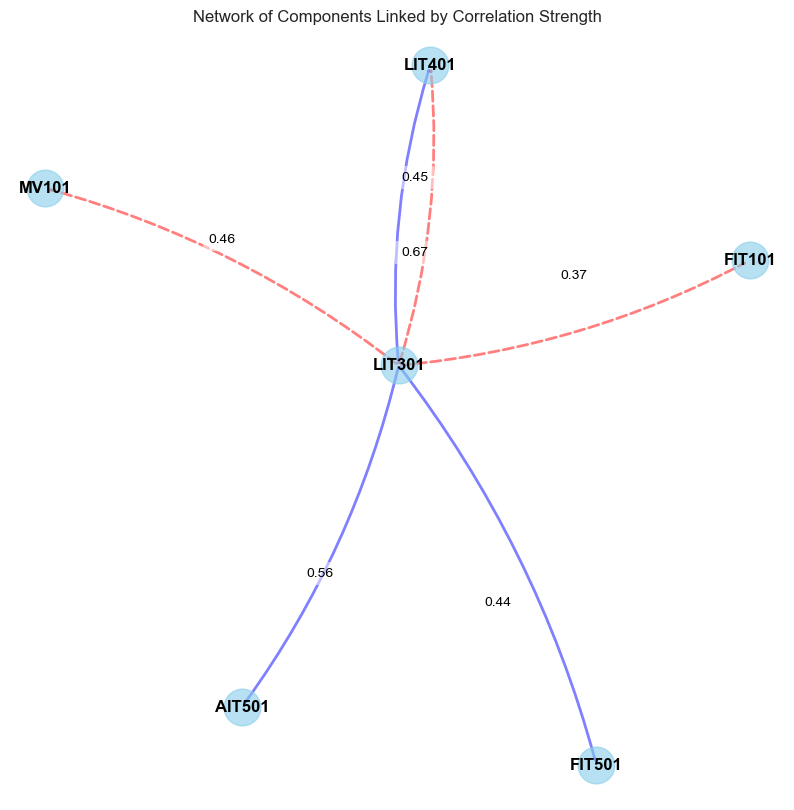

In [23]:
plot_correlation_network(components['LIT301'], top_n_corrs= 3)

## Compare Two Components Linear & Non-Linear Correlations

In [28]:
linear_corr_dict_1 = components['LIT301'].get_strongest_correlated_components('linear', top_n_corrs =4)
non_linear_corr_dict_1 = components['LIT301'].get_strongest_correlated_components('non_linear', top_n_corrs =4)
linear_corr_dict_2 = components['LIT401'].get_strongest_correlated_components('linear', top_n_corrs =4)
non_linear_corr_dict_2 = components['LIT401'].get_strongest_correlated_components('non_linear', top_n_corrs =4)

# Create two components
component1 = components['LIT301']
component2 = components['LIT401']

NameError: name 'Line2D' is not defined

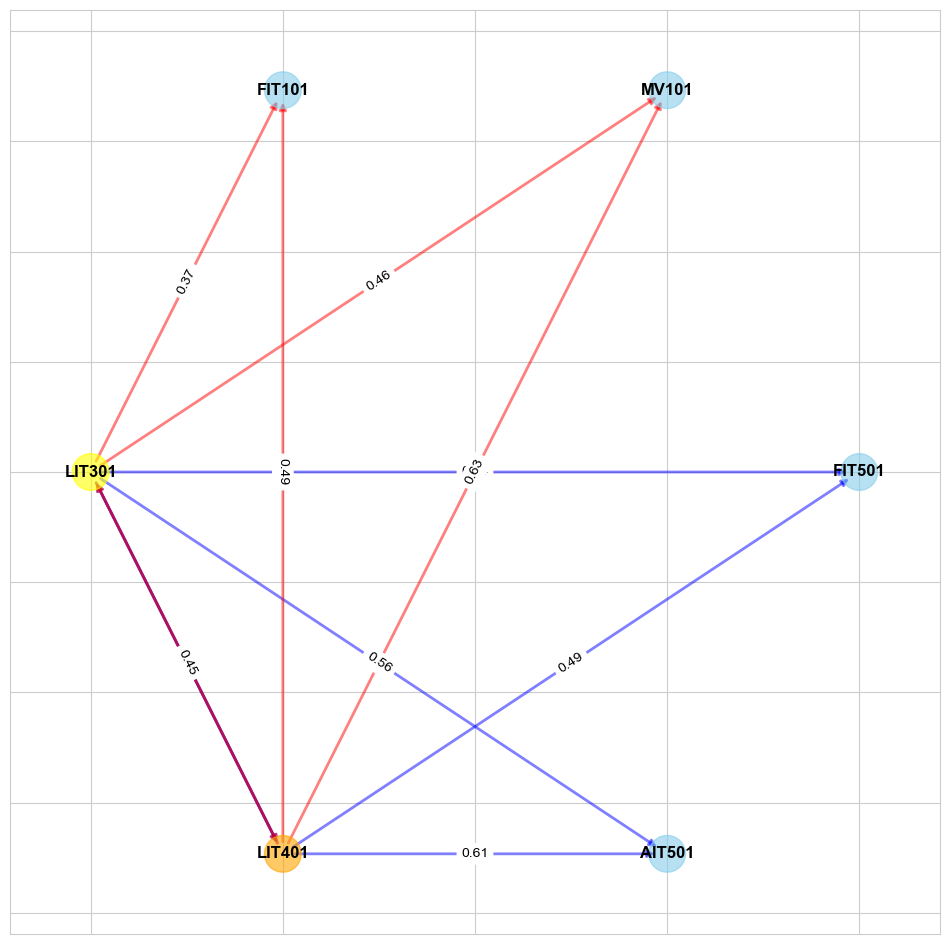

In [32]:
# Plot comparison network for both components
plot_component_comparison(component1 ,component2, linear_corr_dict_1, non_linear_corr_dict_1, linear_corr_dict_2, non_linear_corr_dict_2, top_n_corrs=3, layout= nx.shell_layout)

# Create masks for Spearman and Mutual Information correlations higher than Pearson

This could identify componets such as switches which are strongly correlated but non-linear and would be missed in linear only analysis

In [45]:
# Create masks for Spearman and Mutual Information correlations higher than Pearson
spearman_higher_mask = non_lin_correlation_matrix > correlation_matrix
mutual_info_higher_mask = mutual_info_matrix > correlation_matrix

# Extract values where Spearman correlation is higher than Pearson
spearman_higher_values = non_lin_correlation_matrix[spearman_higher_mask]

# Extract values where Mutual Information correlation is higher than Pearson
mutual_info_higher_values = mutual_info_matrix[mutual_info_higher_mask]

# Combine the extracted values
higher_values = pd.concat([spearman_higher_values, mutual_info_higher_values])

# Plot the higher values
plt.figure(figsize=(10, 6))
sns.barplot(x=higher_values.index, y=higher_values.values, palette='coolwarm')
plt.title('Values where Spearman or Mutual Info are higher than Pearson')
plt.xlabel('Component Pair')
plt.ylabel('Correlation Value')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


NameError: name 'mutual_info_matrix' is not defined

## Observations
P value ( statistical significance) value of 5% indicates 38 of 39 components disprove the null hypothesis that the relationship between components is random. This numebr of related components is acheived by using a Pearson correlation coefficient 0f 0.01 or above ( a very week linear correlation).
These Values were calculated from the correlation from the LIT101 water level sensor which is the main water tank at the beginning of the process ( and so is understandably linked to all other components to some degree.
Restricted the results to correlation coefficients above 0.6 identifies 5 componnets with strong correlations, all of which are in the same or following stage and are related to the movement of water ( pumps or flow sensors). This suggests the Pearson values are more useful is revelaing system dependencies.


# Kernel Distributions

Get distributions for each variable. Get range, divide into 100 bins then count variables ineach. Visualise in plot

In [33]:
# make new df to hold variable distributions
df_distributions = pd.DataFrame()

Sample df as 10 second mean for all values so df is 10% of original to east manipulation

In [34]:
def plotBinCounts(name, bin_counts, bin_edges):
    '''
    Function to plot the distribution of bin counts.
    Parameters:
    - bin_counts: a pandas Series containing the counts of values in each bin.
    - bin_edges: an array containing the bin edges.
    '''

    # Set the size of the plot
    plt.figure(figsize=(10,6))

    # Plot the bin counts
    bin_counts.plot(kind='bar', logy=True)

    # Set the title and labels
    plt.title(f'Distribution of {name}')
    plt.ylabel('Counts')

    # Calculate total range and step size for approximately 10 divisions
    total_range = bin_edges[-1] - bin_edges[0]
    step_size = total_range / 10

    # Round step size to a whole number (e.g., 10, 20, etc.) that makes sense for your data
    rounded_step_size = round(step_size / 10) * 10

    # Generate custom tick positions and labels
    tick_positions = np.arange(0, len(bin_edges) - 1, rounded_step_size / (bin_edges[1] - bin_edges[0]))
    tick_labels = [f"{bin_edges[int(pos)]:.0f}" for pos in tick_positions]

    # Set x-ticks to represent the overall value range of the bins
    plt.xticks(ticks=tick_positions,
               labels=tick_labels,
               rotation=45)  # Rotate labels for better readability

    # Optional: Set x-axis label
    plt.xlabel('Value Range')

    # Show the plot
    plt.show()

# Example usage:
# Assuming bin_counts and bins are obtained from the getDistribution function
# plotBinCounts(bin_counts, bins)


In [38]:
# function to get distribution
def getDistributionBins(variable_col):
    '''
    Function to get distribution of values in variable column.
    Returns
    '''
    #get variable min and max values and calculate range

    var_range = df[variable_col].max() - df[variable_col].min()

    print(f'Var Range:  {var_range}')

    # divide into 100 bins
    bin_size = var_range/100

    # Create bins edges from min to max with using bin_size'
    bins = np.arange(df[variable_col].min(), df[variable_col].max() + bin_size, bin_size)

    # Use pd.cut to segment and sort the data values into bins
    df_distributions[variable_col + '_bins'] = pd.cut(df[variable_col], bins=bins, include_lowest=True)

    # Count the number of values in each bin
    bin_counts = df_distributions[variable_col + '_bins'].value_counts().sort_index()

    # call sisualisation function
    plotBinCounts(variable_col, bin_counts, bins)

    # return bin_counts, bins

Var Range:  696.22615


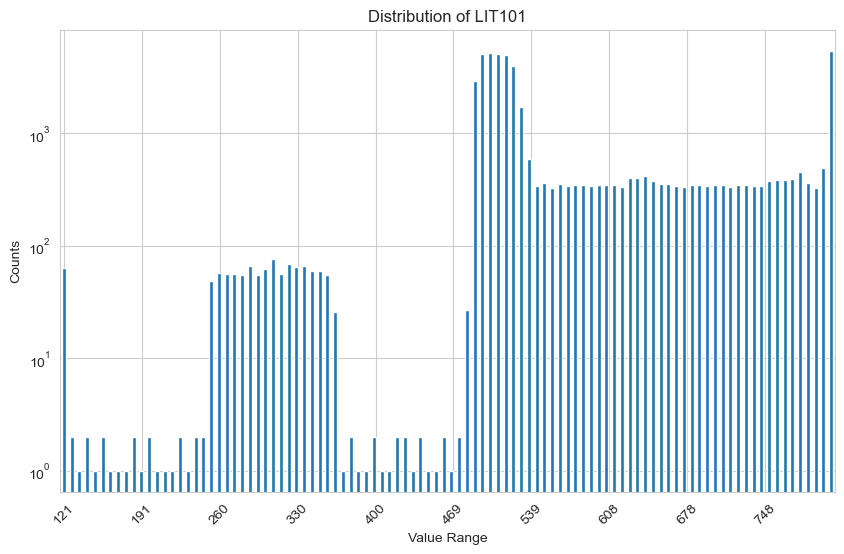

In [39]:
# test with FIT101
#lit101_dist, bins = getDistribution('LIT101')
#plotBinCounts(lit101_dist, bins)

getDistributionBins('LIT101')

In [45]:
from scipy.stats import gaussian_kde

def getKDEDensity(variable_col, bandwidth_adjust=1):
    '''
    Function to generate and plot kernel density estimate for a variable column using scipy's gaussian_kde.

    Parameters:
    variable_col: str - column name from the dataframe
    bandwidth_adjust: float - factor to adjust bandwidth of the KDE (default is 1)

    Returns nothing but visualizes the KDE plot.
    '''
    # Check if there are any missing values in the variable column
    if df[variable_col].isnull().sum() > 0:
        print(f"Warning: {df[variable_col].isnull().sum()} missing values in {variable_col}, filling with median.")
        df[variable_col].fillna(df[variable_col].median(), inplace=True)

    # Extract the data and convert to numpy array
    data = df[variable_col].dropna().values

    # Calculate KDE using scipy's gaussian_kde
    kde = gaussian_kde(data, bw_method='scott' * bandwidth_adjust)  # 'scott' is the default bandwidth estimator

    # Create a grid of values over which to evaluate the KDE
    x_grid = np.linspace(data.min(), data.max(), 1000)  # 1000 points between min and max of the data

    # Evaluate KDE on the grid
    kde_values = kde(x_grid)

    # Plot the KDE
    plt.figure(figsize=(10, 6))
    plt.plot(x_grid, kde_values, color='blue', lw=2)
    plt.fill_between(x_grid, kde_values, color='skyblue', alpha=0.5)

    # Add title and labels
    plt.title(f'Kernel Density Estimate of {variable_col}', fontsize=16)
    plt.xlabel(variable_col, fontsize=12)
    plt.ylabel('Density', fontsize=12)

    # Show plot
    plt.show()


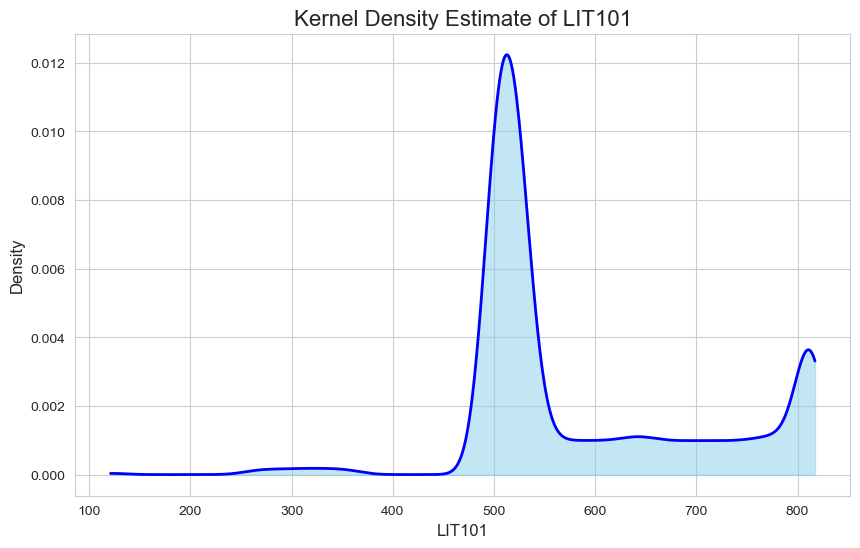

In [46]:
getKDEDensity('LIT101')

# Calculate mutual information between features
mutual_info_matrix = pd.DataFrame(index=df.columns, columns=df.columns)

# Calculate mutual information
for col1 in df.columns:
    for col2 in df.columns:
        mutual_info = mutual_info_regression(df[[col1]], df[col2])[0]
        mutual_info_matrix.loc[col1, col2] = mutual_info

# Display the mutual information matrix
print(mutual_info_matrix)


In [44]:
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.metrics import mutual_info_score

def kde_mutual_information(x_col, y_col, num_points=100):
    '''
    Function to calculate mutual information between two variables using Kernel Density Estimation (KDE).

    Parameters:
    x_col: np.array or pd.Series - first variable
    y_col: np.array or pd.Series - second variable
    num_points: int - the number of grid points for KDE

    Returns:
    Mutual information between the two variables.
    '''

    # Ensure inputs are numpy arrays
    x_col = np.array(x_col)
    y_col = np.array(y_col)

    # Kernel Density Estimate for joint distribution p(x, y)
    kde_joint = gaussian_kde(np.vstack([x_col, y_col]))

    # Kernel Density Estimate for marginal distributions p(x) and p(y)
    kde_x = gaussian_kde(x_col)
    kde_y = gaussian_kde(y_col)

    # Create a grid of values where we will estimate the densities
    x_min, x_max = x_col.min(), x_col.max()
    y_min, y_max = y_col.min(), y_col.max()

    # Create grid points
    x_grid = np.linspace(x_min, x_max, num_points)
    y_grid = np.linspace(y_min, y_max, num_points)
    X, Y = np.meshgrid(x_grid, y_grid)
    positions = np.vstack([X.ravel(), Y.ravel()])

    # Estimate densities on the grid
    p_xy = kde_joint(positions).reshape(num_points, num_points)  # Joint density
    p_x = kde_x(x_grid)  # Marginal density for x
    p_y = kde_y(y_grid)  # Marginal density for y

    # Normalize the densities to get probability values
    p_xy /= np.sum(p_xy)  # Normalize joint density
    p_x /= np.sum(p_x)    # Normalize x marginal density
    p_y /= np.sum(p_y)    # Normalize y marginal density

    # Calculate mutual information
    mi = 0.0
    for i in range(num_points):
        for j in range(num_points):
            if p_xy[i, j] > 0 and p_x[i] > 0 and p_y[j] > 0:
                mi += p_xy[i, j] * np.log(p_xy[i, j] / (p_x[i] * p_y[j]))

    return mi

# Example usage
x_col_name = 'LIT301'
y_col_name = 'LIT401'
x_col = df[x_col_name]
y_col = df[y_col_name]

mi = kde_mutual_information(x_col, y_col)
print(f'Mutual Information between {x_col_name} and {y_col_name}: {mi}')


Mutual Information between LIT301 and LIT401: 0.9706353490603138


1,FIT-101,Sensor,Flow meter; Measures inflow into raw water tank.
2,LIT-101,Sensor,Level Transmitter; Raw water tank level.
3,MV-101,Actuator,Motorized valve; Controls water flow to the raw water tank.

Var Range:  1.9


C:\Users\laure\AppData\Local\Temp\ipykernel_19136\2836748902.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  tick_positions = np.arange(0, len(bin_edges) - 1, rounded_step_size / (bin_edges[1] - bin_edges[0]))


ValueError: Maximum allowed size exceeded

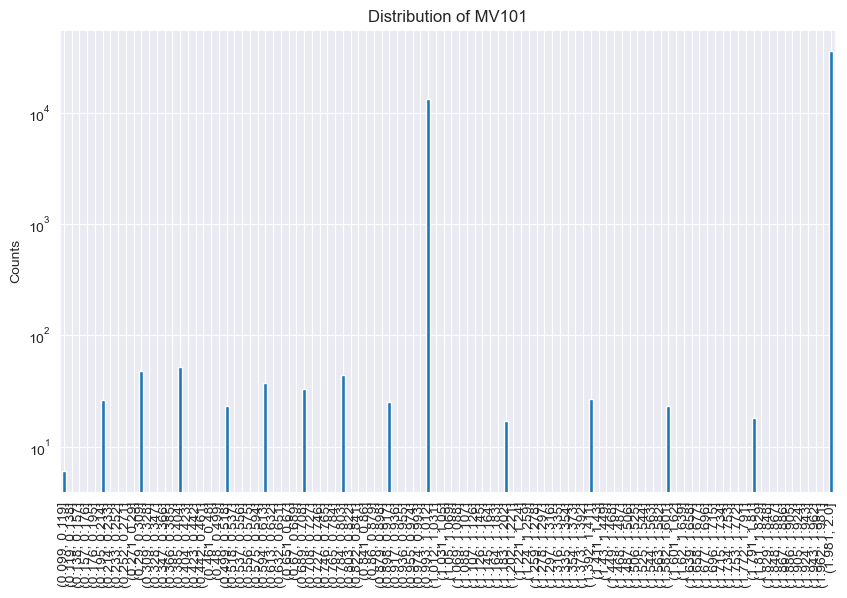

In [294]:
getDistribution('MV101')

In [ ]:
getDistribution('FIT101')

In [ ]:
getDistribution('P101')

# Dim Reduction of Corr Matrix

In [ ]:
# Calculate the linear correlation matrix
correlation_matrix = df.corr().round(decimals= 4)

In [317]:
correlation_matrix = correlation_matrix.drop(columns = 'Correlation Type')

In [320]:
correlation_matrix.

,FIT101,LIT101,MV101,P101,AIT201,AIT202,AIT203,FIT201,MV201,P203,...,FIT501,FIT502,FIT503,FIT504,P501,PIT501,PIT502,PIT503,FIT601,P602
FIT101,1.0000,-0.6478,0.9805,0.2205,-0.0021,-0.0864,0.0320,0.2267,0.2223,0.2287,...,0.0253,0.0269,0.0155,0.0048,0.0155,0.0266,0.0542,0.0284,0.0589,0.0565
LIT101,-0.6478,1.0000,-0.6527,-0.6587,0.0044,0.2195,-0.1380,-0.6668,-0.6591,-0.6671,...,0.1770,0.1726,0.1800,0.1875,0.1818,0.1660,-0.0271,0.1620,-0.0676,-0.0648
MV101,0.9805,-0.6527,1.0000,0.2337,-0.0020,-0.0899,0.0338,0.2399,0.2356,0.2419,...,0.0248,0.0263,0.0152,0.0044,0.0152,0.0264,0.0537,0.0282,0.0593,0.0569
P101,0.2205,-0.6587,0.2337,1.0000,0.0016,-0.3130,0.1253,0.9949,0.9940,0.9956,...,0.0477,0.0484,0.0404,0.0340,0.0410,0.0452,0.0508,0.0454,0.0492,0.0494
AIT201,-0.0021,0.0044,-0.0020,0.0016,1.0000,-0.1015,-0.3301,0.0026,-0.0013,0.0010,...,0.1101,0.1223,0.0583,0.0597,0.0837,0.0383,-0.1904,0.0234,-0.0000,0.0003
AIT202,-0.0864,0.2195,-0.0899,-0.3130,-0.1015,1.0000,0.3652,-0.3150,-0.3113,-0.3152,...,-0.0418,-0.0478,-0.0084,-0.0033,-0.0199,-0.0022,-0.0314,0.0027,-0.0357,-0.0344
AIT203,0.0320,-0.1380,0.0338,0.1253,-0.3301,0.3652,1.0000,0.1288,0.1233,0.1256,...,-0.0879,-0.1115,0.0136,0.0088,-0.0328,0.0466,0.0389,0.0678,0.0098,0.0096
FIT201,0.2267,-0.6668,0.2399,0.9949,0.0026,-0.3150,0.1288,1.0000,0.9867,0.9980,...,0.0475,0.0480,0.0408,0.0342,0.0411,0.0461,0.0521,0.0465,0.0513,0.0511
MV201,0.2223,-0.6591,0.2356,0.9940,-0.0013,-0.3113,0.1233,0.9867,1.0000,0.9910,...,0.0251,0.0264,0.0181,0.0123,0.0188,0.0232,0.0430,0.0237,0.0473,0.0480
P203,0.2287,-0.6671,0.2419,0.9956,0.0010,-0.3152,0.1256,0.9980,0.9910,1.0000,...,0.0482,0.0489,0.0408,0.0343,0.0414,0.0458,0.0511,0.0460,0.0500,0.0501


In [325]:
cluster_labels

array([2, 5, 2, 0, 1, 5, 5, 0, 0, 0, 0, 0, 0, 1, 2, 0, 2, 5, 5, 0, 1, 5,
       3, 1, 3, 3, 1, 5, 1, 4, 3, 3, 3, 3, 3, 3, 5, 3, 2, 2], dtype=int64)

In [324]:
reduced_data

array([[ 0.8444442 ,  0.38382379],
       [-0.1603704 ,  1.85611936],
       [ 0.85560205,  0.33339269],
       [ 1.225623  , -1.76592684],
       [ 0.38165774,  0.43395791],
       [ 0.83450993,  1.44710877],
       [ 1.31322371,  0.5328756 ],
       [ 1.22376103, -1.75263481],
       [ 1.29727993, -1.7417867 ],
       [ 1.22291673, -1.76107548],
       [ 0.9444135 , -1.46754753],
       [ 0.95085268, -1.62326973],
       [ 0.93281976, -1.60376618],
       [-1.0604472 ,  1.29358437],
       [ 0.91281981,  0.99005304],
       [ 0.94624128, -1.53282137],
       [ 0.88756771,  1.08426256],
       [ 0.82605069,  0.90890997],
       [ 1.92579986,  0.67949131],
       [ 0.76528249, -1.5576894 ],
       [ 0.13725922,  0.31304588],
       [ 1.25385442,  0.58345803],
       [-2.43276031, -0.11442555],
       [-0.92744384, -0.1352789 ],
       [-2.41348721, -0.09884656],
       [-2.41769723, -0.09938601],
       [-1.45587927,  0.23880542],
       [ 1.46647262,  0.62491774],
       [ 0.54396317,

IndexError: list index out of range

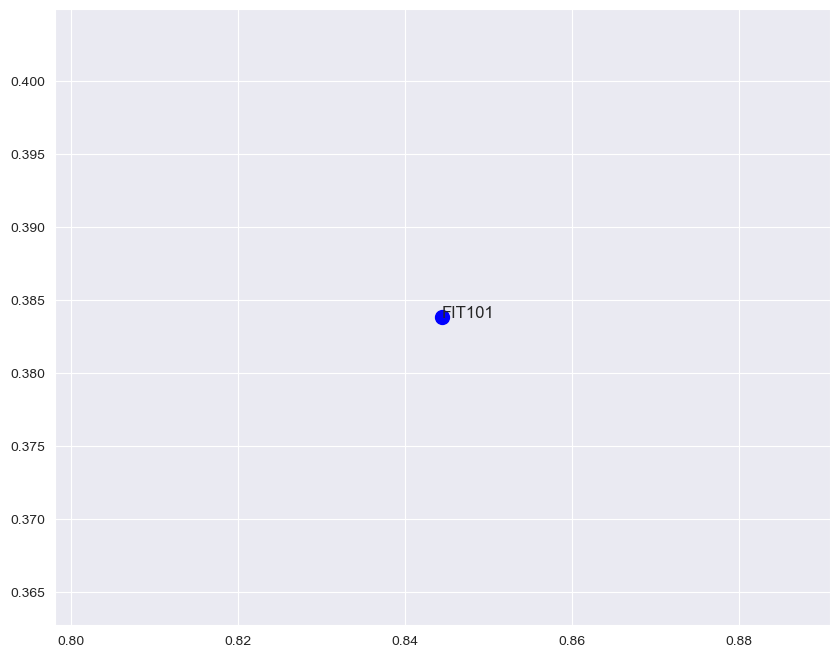

In [318]:
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Step 2: Apply Agglomerative Clustering
# Perform hierarchical clustering
agg_cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
cluster_labels = agg_cluster.fit_predict(correlation_matrix)

# Step 2: Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(correlation_matrix)

# Step 3: Plot the results
plt.figure(figsize=(10, 8))
# Use different colors for different clusters
colors = ['red', 'green', 'blue']
for i in range(len(reduced_data)):
    plt.scatter(reduced_data[i, 0], reduced_data[i, 1],
                color=colors[cluster_labels[i]], label=f'Cluster {cluster_labels[i]}' if i == 0 else "", s=100)
    plt.text(reduced_data[i, 0], reduced_data[i, 1], correlation_matrix.columns[i], fontsize=12)

plt.title('2D PCA of Correlation Matrix with Agglomerative Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend()
plt.show()

In [359]:

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D

# Example correlation matrix (replace with your actual correlation matrix)
np.random.seed(0)

# Step 1: Standardize the correlation matrix (optional but often recommended)
#scaler = StandardScaler()
#correlation_matrix_scaled = scaler.fit_transform(correlation_matrix)



# Step 3: Apply PCA to reduce to 3 dimensions
pca = PCA(n_components=6)
reduced_data = pca.fit_transform(correlation_matrix)

# Step 2: Apply Agglomerative Clustering
agg_cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
cluster_labels = agg_cluster.fit_predict(reduced_data)


# Step 3: Create a DataFrame to show which variables belong to which cluster
cluster_df = pd.DataFrame({
    'Variable': correlation_matrix.columns,
    'Cluster': cluster_labels
})

grouped = cluster_df_sorted.groupby(by='Cluster')['Variable'].apply(list)
grouped




Cluster
0    [P302, P101, FIT201, MV201, P203, P205, DPIT30...
1     [AIT503, AIT501, AIT201, LIT401, AIT401, LIT301]
2          [FIT601, FIT101, P602, MV301, MV101, MV303]
3    [PIT503, PIT501, FIT401, P501, P402, UV401, FI...
4                                             [AIT504]
5    [PIT502, MV304, AIT202, AIT402, AIT203, P301, ...
Name: Variable, dtype: object

Cluster
0    [P302, P101, FIT201, MV201, P203, P205, DPIT30...
1     [AIT503, AIT501, AIT201, LIT401, AIT401, LIT301]
2          [FIT601, FIT101, P602, MV301, MV101, MV303]
3    [PIT503, PIT501, FIT401, P501, P402, UV401, FI...
4                                             [AIT504]
5    [PIT502, MV304, AIT202, AIT402, AIT203, P301, ...
Name: Variable, dtype: object

In [ ]:
# Display the grouped components by cluster and forast for latex

# Latex table code
latex_table = "\\begin{table}[h!]\n\\centering\n\\begin{tabular}{|c|l|c|}\n\\hline\n"
latex_table += "Cluster & Components & No. Components \\\\\n\\hline\n"

for cluster, components in clusters.items():
    # Split components into lines with a max of 10 components per line
    component_lines = [', '.join(components[i:i+10]) for i in range(0, len(components), 10)]
    component_str = ' \\\\ '.join(component_lines)
    latex_table += f"{cluster} & {component_str}  \\\\\n"

latex_table += "\\hline\n\\end{tabular}\n\\caption{Clustered Components}\n\\label{tab:clusters}\n\\end{table}"

print(latex_table)

In [360]:
agg_cluster

AgglomerativeClustering(n_clusters=6)

In [361]:
# Step 2: Apply Agglomerative Clustering
agg_cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
cluster_labels = agg_cluster.fit_predict(correlation_matrix)

# Step 3: Create a DataFrame to show which variables belong to which cluster
cluster_df = pd.DataFrame({
    'Variable': correlation_matrix.columns,
    'Cluster': cluster_labels
})

# Step 4: Sort by cluster for better readability
cluster_df_sorted = cluster_df.sort_values(by='Cluster').reset_index(drop=True)

# Display the DataFrame
print(cluster_df_sorted)

   Variable  Cluster
0      P302        0
1      P101        0
2    FIT201        0
3     MV201        0
4      P203        0
5      P205        0
6   DPIT301        0
7    FIT301        0
8     MV302        0
9    AIT503        1
10   AIT501        1
11   AIT201        1
12   LIT401        1
13   AIT401        1
14   LIT301        1
15   FIT601        2
16   FIT101        2
17     P602        2
18    MV301        2
19    MV101        2
20    MV303        2
21   PIT503        3
22   PIT501        3
23   FIT401        3
24     P501        3
25     P402        3
26    UV401        3
27   FIT504        3
28   FIT501        3
29   FIT502        3
30   FIT503        3
31   AIT504        4
32   PIT502        5
33    MV304        5
34   AIT202        5
35   AIT402        5
36   AIT203        5
37     P301        5
38   AIT502        5
39   LIT101        5


In [362]:
# Step 3: Create a DataFrame to show which variables belong to which cluster
cluster_df = pd.DataFrame({
    'Variable': correlation_matrix.columns,
    'Cluster': cluster_labels
})

grouped = cluster_df_sorted.groupby(by='Cluster')['Variable'].apply(list)
grouped

Cluster
0    [P302, P101, FIT201, MV201, P203, P205, DPIT30...
1     [AIT503, AIT501, AIT201, LIT401, AIT401, LIT301]
2          [FIT601, FIT101, P602, MV301, MV101, MV303]
3    [PIT503, PIT501, FIT401, P501, P402, UV401, FI...
4                                             [AIT504]
5    [PIT502, MV304, AIT202, AIT402, AIT203, P301, ...
Name: Variable, dtype: object

In [349]:
type(cluster_df_sorted)

pandas.core.frame.DataFrame

In [350]:
print(cluster_df_sorted.groupby('Cluster'))

In [343]:
from sklearn.decomposition import FactorAnalysis

# Assuming 'data' is your original dataset
fa = FactorAnalysis(n_components=6)  # You can choose the number of factors
fa.fit(correlation_matrix)

# Transformed data with reduced dimensions
transformed_data = fa.transform(correlation_matrix)

In [344]:
transformed_data

array([[ 5.85213169e-01,  1.16224639e-01,  9.89270086e-02,
        -9.12290331e-01, -1.53925761e+00, -1.25394093e-01],
       [-1.37094565e-01,  2.39221100e+00, -5.00364480e-01,
         1.38472545e+00,  3.01348643e-01, -3.14770061e-01],
       [ 5.91576713e-01,  7.80845233e-02,  9.83043372e-02,
        -8.78065838e-01, -1.47754155e+00, -1.25741914e-01],
       [ 8.57970021e-01, -2.06196424e+00, -3.17051751e-02,
        -6.11443712e-01, -5.02409800e-01,  3.54072436e-01],
       [ 3.87508694e-01,  6.70793441e-01, -1.77060072e+00,
         2.66053341e-01, -3.90891512e-01,  2.90342161e-01],
       [ 4.13791645e-01,  1.58867562e+00,  3.25275746e-01,
         6.56639338e-01, -3.89971440e-01,  1.64748981e+00],
       [ 5.66034513e-01,  3.52058956e-01,  1.83933189e+00,
         2.45295027e-01, -3.06587539e-01,  3.44839084e+00],
       [ 8.57968560e-01, -2.06667105e+00, -1.99401491e-02,
        -6.48015294e-01, -5.41250412e-01,  3.66664392e-01],
       [ 9.02860732e-01, -2.03023929e+00, -3.730